## Model Import and Testing Interface



In [1]:
import pandas as pd
import os
import io
import sys
import math
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
import ipydatetime
import IPython
import csv
import numpy as np
import seaborn as sns
from IPython.display import display
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from keras.models import load_model
import fileupload
from ipywidgets import FileUpload
import datetime
from datetime import datetime
import random
sys.path.append('..')
from data_loaders import empatica
from prediction import model
from preprocessing import split

In [2]:
radiobut = True
model_select = widgets.RadioButtons(
        options=[''],
        value= '',
        description='Models:',
        disabled=False
    )

if os.path.isdir(os.path.join(os.getcwd() + "/models")):
    dir_list = os.listdir(os.path.join(os.getcwd() + "/models"))
    model_select.options = dir_list

else:
    radiobut = False
    model_select = widgets.Text(
    value='',
    placeholder='Type something',
    description='File Path:',
    disabled=False
)
info = widgets.Label('Select or Upload Model')
display(info)
freq = widgets.Output()
display(model_select,freq)


data_select = widgets.Text(
    value='',
    placeholder='Type something',
    description='File Path:',
    disabled=False
)
info = widgets.Label('Input path for the data set you wish to label')
display(info)
data = widgets.Output()
display(data_select, data)

data_select.value = os.path.join(os.getcwd(), 'exampleFile.csv')

Label(value='Select or Upload Model')

RadioButtons(description='Models:', options=('braz.h5', 'hannah.h5', 'model.h5'), value='braz.h5')

Output()

Label(value='Input path for the data set you wish to label')

Text(value='', description='File Path:', placeholder='Type something')

Output()

One-hot-encoding: category names -> int -> one-hot
{'Sitting': 0, 'Standing': 1}
One-hot-encoding [array([0, 1], dtype=int64)]


Label(value='This button will add labels to the dataset')

Button(description='Add Labels', style=ButtonStyle())

{0: 'Running', 1: 'Jogging', 2: 'Walking', 3: 'Sitting', 4: 'Standing', 5: 'Undefined'}
Final Predicted Label Counts
[['Jogging' '89']
 ['Running' '29']]


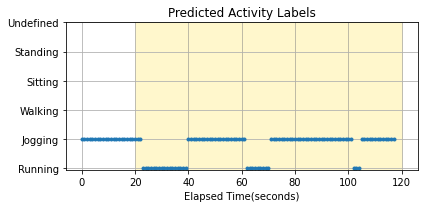

              precision    recall  f1-score   support

     Jogging       1.00      0.51      0.67        57
     Running       0.69      1.00      0.81        61

    accuracy                           0.76       118
   macro avg       0.84      0.75      0.74       118
weighted avg       0.84      0.76      0.75       118



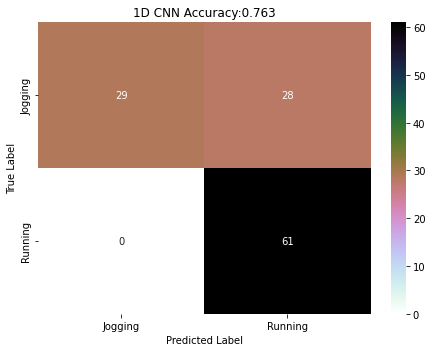

In [4]:
"""
citations:
getting name of a file without the extension:       https://theprogrammingexpert.com/python-remove-extension/
interesting techniques for labeling df:             https://www.geeksforgeeks.org/label-based-indexing-to-the-pandas-dataframe/
fill in values of df according to dictionary:       https://stackoverflow.com/questions/64481108/assign-a-value-between-index-values-ranges-in-pandas

"""

def getNPdimensions(filename_without_ext):
    filename = filename_without_ext.removesuffix('.h5')
    filename = filename + ".csv"
    path = os.path.join(os.getcwd(), "np_dimensions")
    np_dimensions = []
    if os.path.isfile(os.path.join(path, filename)):
        fileList = pd.read_csv(os.path.join(path, filename))
        np_dimensions = list(fileList)
    np_dimensions[0] = int(math.floor(float(np_dimensions[0])))
    np_dimensions[1] = int(math.floor(float(np_dimensions[1])))
    return np_dimensions




if radiobut:
    previousPath = os.getcwd()
    os.chdir('models')
    modelPath = os.path.join(os.getcwd(), model_select.value)
    new_model = load_model(modelPath)
    os.chdir(previousPath)
    
    """
    filename = os.path.basename(modelPath)
    filename_without_ext = os.path.splitext(filename)[0]
    print(filename_without_ext)
    np_dimensions = getNPdimensions(filename_without_ext)
    """

elif(os.path.isfile(model_select.value)):
    new_model = load_model(model_select.value)

if data_select.value != '':
    df = pd.read_csv(data_select.value)
    dfA = df.set_index('datetime')

np_dimensions = getNPdimensions(model_select.value)
new_np = split.NParrays(*np_dimensions)
new_np.setArrays(dfA)

cnn = model.CNN()
testModel = model.CNN()
testModel.setModel(new_model)
testModel.only_test_data(new_np.x, new_np.y)

def label_confidence(l):
    return max(l)/sum(l)

def pred_to_labels(predictions):
    y_pred = np.argmax(predictions, axis=-1)
    y_pred_labels = np.vectorize(labels_dict.get)(y_pred)
    return y_pred_labels

def labels_to_dict(labels):
    label_frame =pd.read_csv(labels)
    labels = list(label_frame)
    label_dict = {}
    for i in range(len(labels)):
        label_dict[labels[i]] = i
    return dict([(value, key) for key, value in label_dict.items()])


def flag_sus_labels(npObject, labels_dict, labels, model, CON_THRESHOLD):
    label_frame = pd.read_csv(labels)
    labels = list(label_frame)

    predictions = model.predict(npObject.x, verbose = 0, batch_size = 32)
    y_pred = np.argmax(predictions, axis=-1)
    y_pred_labels = np.vectorize(labels_dict.get)(y_pred)
    unique, counts = np.unique(y_pred_labels, return_counts=True)
    
    fig, ax = plt.subplots(1,1,figsize=(6,3))
    ax.plot(y_pred,linestyle="",marker=".")
    plt.title('Predicted Activity Labels')
    ax.set_xlabel('Elapsed Time(seconds)')

    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.grid()

    for i in range(0, len(predictions), 20):
        if sum([label_confidence(j)<CON_THRESHOLD for j in predictions[i:i+20]]) >0:
            plt.axvspan(i, i+20, color='gold', alpha=0.2)

    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
    plt.show()

def labelDf(df, labels_dict, model, npObject):

    #copy the dataframe and initialize all predicted labels to Undefined
    labeledDf = df
    labeledDf['pred_labels'] = "Undefined"
    
    #reformat y_pred to hold the string values for labels
    predictions = model.predict(npObject.x, verbose = 0, batch_size = 32)
    y_pred = np.argmax(predictions, axis=-1)
    y_pred_labels = np.vectorize(labels_dict.get)(y_pred)
    unique, counts = np.unique(y_pred_labels, return_counts=True)

    #print out relevant information about labels and dictionary
    print(labels_dict)
    print("Final Predicted Label Counts")
    print (np.asarray((unique, counts)).T)
    #label the new dataframe
    
    for z in range(y_pred_labels.size):
        start = npObject.time[z][0]
        end = npObject.time[z][1]
        labeledDf.loc[start : end, ['pred_labels']] = y_pred_labels[z]

def confusion_mat(npObject, model, labelLoc):
    labels_dict = labels_to_dict(labelLoc)

    predictions = model.model.predict(npObject.x, verbose = 0, batch_size = 32)
    y_pred = np.argmax(predictions, axis=-1)
    y_pred_labels = np.vectorize(labels_dict.get)(y_pred)
    unique, counts = np.unique(y_pred_labels, return_counts=True)

    test_acc , y_pred = model.run()
    y_test_act = np.argmax(npObject.y, axis=-1)
    class_rpt_for_log = classification_report(y_test_act, y_pred, target_names = unique)
    print(class_rpt_for_log)

    cm = confusion_matrix(y_test_act, y_pred)
    cm_df = pd.DataFrame(cm, index = unique, columns = unique)
    fig = plt.figure(figsize=(6.5,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap= 'cubehelix_r')
    plt.title('1D CNN Accuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

info = widgets.Label('This button will add labels to the dataset')
display(info)
def clicked(arg):
    labelDf(df, labels_to_dict(os.path.join(os.getcwd(), 'testLabelList.csv')), testModel.model, new_np)
    flag_sus_labels(new_np, labels_to_dict(os.path.join(os.getcwd(), 'testLabelList.csv')),os.path.join(os.getcwd(), 'testLabelList.csv'), testModel.model, 0.99)
    confusion_mat(new_np ,testModel, os.path.join(os.getcwd(), 'testLabelList.csv')
    
    )
button_download = widgets.Button(description = 'Add Labels')   
button_download.on_click(clicked)
display(button_download)